Tathiane Souza

## 1. Explorando os dados


Esta pesquisa utiliza dados sobre pagamentos de clientes de Taiwan fazendo uma análise sobre a inadimplência.




In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, classification_report, precision_recall_curve, average_precision_score, roc_curve, auc
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

Agora, você pode descobrir os seguintes fatos sobre o conjunto de dados?

- Número total de consumidores
- Número de onsumidores que efetuaram o pagamento
- Número de consumidores que não efetuaram o pagamento
- Taxa de pagantes (%)


In [3]:

credit_data = pd.read_csv("UCI_Credit_Card.csv")
print( "successo!")


successo!


In [4]:
# Dataset Carregado, limitando as 10 primeira linhas
credit_data.head(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,next_payment
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


In [6]:
credit_data.isnull().sum() #verificação se há valores nulos

ID              0
LIMIT_BAL       0
SEX             0
EDUCATION       0
MARRIAGE        0
AGE             0
PAY_0           0
PAY_2           0
PAY_3           0
PAY_4           0
PAY_5           0
PAY_6           0
BILL_AMT1       0
BILL_AMT2       0
BILL_AMT3       0
BILL_AMT4       0
BILL_AMT5       0
BILL_AMT6       0
PAY_AMT1        0
PAY_AMT2        0
PAY_AMT3        0
PAY_AMT4        0
PAY_AMT5        0
PAY_AMT6        0
next_payment    0
dtype: int64

In [7]:
n_consumers = credit_data.shape[0]
n_features = credit_data.shape[1]-1
n_paying = credit_data.next_payment[credit_data.next_payment == 1].count()
n_failed = credit_data.next_payment[credit_data.next_payment == 0].count()
grad_rate = (float(n_paying) / n_consumers) * 100.0
print ("Total de clientes: {}".format(n_consumers))
print ("Número de clients que pagaram: {}".format(n_paying))
print ("Número de clientes que não pagaram: {}".format(n_failed))
print ("Número de colunas de características: {}".format(n_features))
print ("Taxa de pagamento: {:.2f}%".format(grad_rate))

Total de clientes: 30000
Número de clients que pagaram: 6636
Número de clientes que não pagaram: 23364
Número de colunas de características: 24
Taxa de pagamento: 22.12%


## 2. Preparando os dados
Nesta seção, prepararemos os dados para modelagem, treinamento e teste.

### Identificar colunas de características e de destino

Separado os dados em colunas de características e de destino e ver se se esses dados não são numéricos. <br/>
** Nota **: Para este conjunto de dados, a última coluna (`'next_payment'`) é o destino que estamos tentando prever.

In [8]:
feature_cols = list (credit_data.columns [1:-1])
target_col = credit_data.columns [-1] #  coluna de destino
print ("coluna (s) de características: - \n {}". format (feature_cols))
print ("\ncoluna de destino: {}". format (target_col))

X_all = credit_data [feature_cols] # feactures-caracteristicas
y_all = credit_data [target_col] # next_payment
print ("\n Características: -")
print (X_all.head ()) # imprime as primeiras 5 linhas
print (y_all.head ()) 

coluna (s) de características: - 
 ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

coluna de destino: next_payment

 Características: -
   LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0      20000    2          2         1   24      2      2     -1     -1   
1     120000    2          2         2   26     -1      2      0      0   
2      90000    2          2         2   34      0      0      0      0   
3      50000    2          2         1   37      0      0      0      0   
4      50000    1          2         1   57     -1      0     -1      0   

   PAY_5  ...  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  \
0     -2  ...        689          0          0          0         0       689   
1      0  ...       2682       3272      

## 3. Pré-processamento dos dados

 OneHotEncoder, não é necessario pois todos os dados são numéricos

In [9]:
# Colunas de recurso de pré-processamento
#def preprocess_features(X):
#    outX = pd.DataFrame(index=X.index) 
#    #Verifique cada coluna
#    for col, col_data in X.iteritems():
#        if col_data.dtype == object:
#            col_data = pd.get_dummies(col_data, prefix=col)  

#        outX = outX.join(col_data) 
#    return outX

#X_all = preprocess_features(X_all)
print ("Colunas processadas ({}):-\n{}".format(len(X_all.columns), list(X_all.columns)))
X_all.head(3)

Colunas processadas (23):-
['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000


In [10]:
#scaler = StandardScaler()
#credit_data2 = scaler.fit_transform(credit_data)
#credit_data2

### Dividir os dados em conjuntos de treinamento e teste

In [11]:
# Primeiro, decida quantas amostras de treinamento e teste você deseja
#from sklearn.cross_validation import train_test_split
num_all = credit_data.shape[0]  
from sklearn.model_selection import train_test_split
num_train = 20000  
num_test = num_all - num_train

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, train_size=20000)
print ("Conjunto de treinamento: {} ".format(X_train.shape[0]))
print ("Conjunto de teste: {} ".format(X_test.shape[0]))

Conjunto de treinamento: 20000 
Conjunto de teste: 10000 


## 4. Treinando e avaliando modelos
Escolhi os seguintes modelos, para essa avaliação supervisionada:
 - Logistic Regression
 - Decision Tree
 - SVC
 - GaussianNB
 - Perceptron

In [12]:
# Treinando o modelo
import time

def train_classifier(clf, X_train, y_train):
    print ("Treinando {}...".format(clf.__class__.__name__))
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print ("Tempo de treino (secs): {:.3f}".format(end - start))
    return end - start

clf = DecisionTreeClassifier()

# Ajustar o modelo aos dados de treinamento
train_classifier(clf, X_train, y_train)  

Treinando DecisionTreeClassifier...
Tempo de treino (secs): 0.496


0.49567484855651855

In [13]:
# Prever e calcular a pontuação F1
from sklearn.metrics import f1_score

def predict_labels(clf, features, target):
    print ("Prevendo rótulos usando {}...".format(clf.__class__.__name__))
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    print ("Tempo de previsão (secs): {:.3f}".format(end - start))

    return f1_score(target.values, y_pred, pos_label=1, average='micro'), end - start

train_f1_score = predict_labels(clf, X_train, y_train)
print (" F1score para o conjunto de treinamento: {}".format(train_f1_score[0]))


Prevendo rótulos usando DecisionTreeClassifier...
Tempo de previsão (secs): 0.006
 F1score para o conjunto de treinamento: 0.99945


In [14]:
# Prever nos dados de teste
print ("F1score para o conjunto de teste: {}".format(predict_labels(clf, X_test, y_test)[0]))

Prevendo rótulos usando DecisionTreeClassifier...
Tempo de previsão (secs): 0.004
F1score para o conjunto de teste: 0.7252999999999998


### Processando vários modelos

In [15]:
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB 
#classifiers = [DecisionTreeClassifier(), Perceptron()]
classifiers = [DecisionTreeClassifier(), SVC(), GaussianNB(), LogisticRegression(), Perceptron()]
results = { 
        'Classificador': [],
        'Tamanho': [], 
        'Tempo treino': [], 
        'Tempo predisão': [], 
        'F1 score - treino': [], 
        'F1 score - teste': []
    }
datasets = [train_test_split(X_all, y_all, train_size=x, test_size=2500) for x in [5000, 10000, 20000]]
for clf in classifiers:
    for data in datasets:
        X_train, X_test, y_train, y_test = data
        time_train = train_classifier(clf, X_train, y_train)
        f1_train, time_predict = predict_labels(clf, X_train, y_train)
        f1_test, time_predict = predict_labels(clf, X_test,y_test)
        
        results['Classificador'].append(clf.__class__.__name__)
        results['Tamanho'].append(X_train.shape[0])
        results['Tempo treino'].append("{:.3f}".format(time_train))
        results['Tempo predisão'].append("{:.3f}".format(time_predict))
        results['F1 score - treino'].append(f1_train)
        results['F1 score - teste'].append(f1_test)
        
pd.DataFrame(results)

Treinando DecisionTreeClassifier...
Tempo de treino (secs): 0.095
Prevendo rótulos usando DecisionTreeClassifier...
Tempo de previsão (secs): 0.003
Prevendo rótulos usando DecisionTreeClassifier...
Tempo de previsão (secs): 0.002
Treinando DecisionTreeClassifier...
Tempo de treino (secs): 0.179
Prevendo rótulos usando DecisionTreeClassifier...
Tempo de previsão (secs): 0.004
Prevendo rótulos usando DecisionTreeClassifier...
Tempo de previsão (secs): 0.001
Treinando DecisionTreeClassifier...
Tempo de treino (secs): 0.384
Prevendo rótulos usando DecisionTreeClassifier...
Tempo de previsão (secs): 0.006
Prevendo rótulos usando DecisionTreeClassifier...
Tempo de previsão (secs): 0.001
Treinando SVC...
Tempo de treino (secs): 2.276
Prevendo rótulos usando SVC...
Tempo de previsão (secs): 1.815
Prevendo rótulos usando SVC...
Tempo de previsão (secs): 0.927
Treinando SVC...
Tempo de treino (secs): 23.695
Prevendo rótulos usando SVC...
Tempo de previsão (secs): 6.973
Prevendo rótulos usando SV

,Classificador,Tamanho,Tempo treino,Tempo predisão,F1 score - treino,F1 score - teste
0,DecisionTreeClassifier,5000,0.095,0.002,0.99960,0.7252
1,DecisionTreeClassifier,10000,0.179,0.001,0.99960,0.7260
2,DecisionTreeClassifier,20000,0.384,0.001,0.99955,0.7204
3,SVC,5000,2.276,0.927,0.99520,0.7968
4,SVC,10000,23.695,1.727,0.99500,0.7892
5,SVC,20000,147.340,3.703,0.99375,0.7672
6,GaussianNB,5000,0.004,0.002,0.42860,0.4032
7,GaussianNB,10000,0.007,0.002,0.41150,0.4088
8,GaussianNB,20000,0.011,0.002,0.37020,0.3732
9,LogisticRegression,5000,0.128,0.001,0.76740,0.7992


## 5. Redução de dimensionalidade

In [16]:
pca = PCA(n_components=15) # , whiten=True
pca.fit(X_train)
X_train_ = pca.transform(X_train)
X_test_ = pca.transform(X_test)
#X_train_[0], y_train[0]

#clff = SVC()
clff = DecisionTreeClassifier()
clff.fit(X_train_, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [17]:
#pca.components_ 
#var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
#print(var1)
#plt.plot(var1)


In [18]:
train_f1_score2 = predict_labels(clff, X_train_, y_train)
print (" F1score para o conjunto de treinamento: {}".format(train_f1_score2[0]))

Prevendo rótulos usando DecisionTreeClassifier...
Tempo de previsão (secs): 0.006
 F1score para o conjunto de treinamento: 0.99955


In [19]:
# Prever nos dados de teste
print ("F1score para o conjunto de teste: {}".format(predict_labels(clff, X_test_, y_test)[0]))

Prevendo rótulos usando DecisionTreeClassifier...
Tempo de previsão (secs): 0.001
F1score para o conjunto de teste: 0.7148


## 6. Refinando o modelo e mostrando a melhor pontuação de F1

A pontuação final de f1 do meu modelo chegou a 0,8102 para o Decision Tree

Para chegar a essa pontuação, a pesquisa de grade mostrou que definir uma profundidade máxima de 2 nós e o máximo de recursos usando a raiz quadrada de recursos produz o melhor resultado de modelo f1.

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
def performance_metric(label, prediction):
    return f1_score(label, prediction, pos_label=1)

X_train, X_test, y_train, y_test = datasets[2]
parameters = {
    'max_features':['log2', 'sqrt'], 
    'max_depth':[1,2,3,4,5]}

#parameters_perc = {
#    'alpha':[0.0001], 'fit_intercept':[True]}

gnb = GaussianNB()
dtc = DecisionTreeClassifier()
clf = GridSearchCV(dtc, parameters, scoring = make_scorer(performance_metric, greater_is_better=True))
clf.fit(X_train, y_train)
f1_test, time_predict = predict_labels(clf.best_estimator_, X_test,y_test)

print(f1_test)



Prevendo rótulos usando DecisionTreeClassifier...
Tempo de previsão (secs): 0.001
0.8056000000000001


In [21]:
#clf.best_score_


### Outros testes
- Usando Normalização

In [22]:
scaler = StandardScaler()  # normalização

parameters = {
    'max_features':['log2', 'sqrt'], 
    'max_depth':[1,2,3]}

gnb = GaussianNB()
dtc = DecisionTreeClassifier()
clf = GridSearchCV(dtc, parameters, scoring = make_scorer(performance_metric, greater_is_better=True))
pipeline2 = make_pipeline(scaler, clf)

pipeline2.fit(X_train, y_train)

y_true2 = y_test
y_pred2 = pipeline2.predict(X_test)
y_score2 = pipeline2.predict_proba(X_test)[:, 1]

In [23]:
RANDOM_STATE = 10000
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.5, random_state=RANDOM_STATE)

In [24]:
scaler = StandardScaler() # normalização
param_grid = dict(C=np.logspace(-5, 5, 11), penalty=['l1', 'l2'])
regr = LogisticRegression()
cv = GridSearchCV(estimator=regr, param_grid=param_grid, scoring='average_precision')
pipeline = make_pipeline(scaler, cv)

pipeline.fit(X_train, y_train)

y_true = y_test
y_pred = pipeline.predict(X_test) # manterá o valor real da coluna que é o valor de credibilidade. Nesse caso, são apenas os próprios valores de teste.
y_score = pipeline.predict_proba(X_test)[:, 1] # detém os novos valores previstos 

## 7. Avaliando o Modelo

- acurácia
- f1 score
- precision e recal
- curva roc
- matrix de convulsão

In [25]:
#precisão do modelo, porcentagem dos valores que o preditor pode prever corretamente
accuracy_score(y_true=y_true2, y_pred=y_pred2)  # decision tree

0.8156

In [26]:
accuracy_score(y_true=y_true, y_pred=y_pred) #LogisticRegression

0.8088

In [27]:
confusion_matrix(y_true=y_true, y_pred=y_pred) #LogisticRegression

array([[11358,   322],
       [ 2546,   774]], dtype=int64)

In [28]:
confusion_matrix(y_true=y_true2, y_pred=y_pred2) # decision tree

array([[1843,   70],
       [ 391,  196]], dtype=int64)

In [29]:
precision_score(y_true=y_true, y_pred=y_pred) # LogisticRegression

0.7062043795620438

In [30]:
precision_score(y_true=y_true2, y_pred=y_pred2)  # decision tree

0.7368421052631579

In [31]:
recall_score(y_true=y_true, y_pred=y_pred) # LogisticRegression

0.23313253012048193

In [32]:
recall_score(y_true=y_true2, y_pred=y_pred2)  # decision tree

0.3339011925042589

In [33]:
def plot_roc_curve(y_true, y_score):
    from sklearn.metrics import roc_curve, auc
    
    fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(9, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC (auc = {:0.2}'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('Taxa positiva falsa')
    plt.ylabel('Taxa positiva verdadeira')
    plt.title('Curva Roc')
    plt.legend(loc="lower right")

def plot_confusion_matrix(cm, class_names):
    import itertools
   
    cm = cm.astype(np.float) / cm.sum(axis=1)[:, np.newaxis]
 
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matriz de Confulsão')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > cm.max() / 2 else "black"
        plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color=color)
        
    plt.ylabel('Rótulo verdadeiro')
    plt.xlabel('Rótulo previsto')
    plt.show()

- O valor do AUC varia de 0,0 até 1,0 e o limiar entre a classe é 0,5. Ou seja, acima desse limite, o algoritmo classifica em uma classe e abaixo na outra classe. Quanto maior o AUC, melhor.

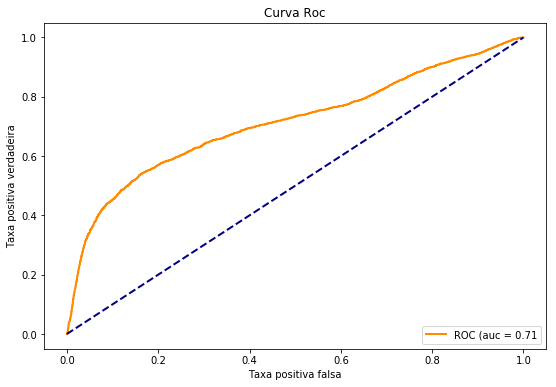

In [34]:
plot_roc_curve(y_true=y_true, y_score=y_score) #LogisticRegression

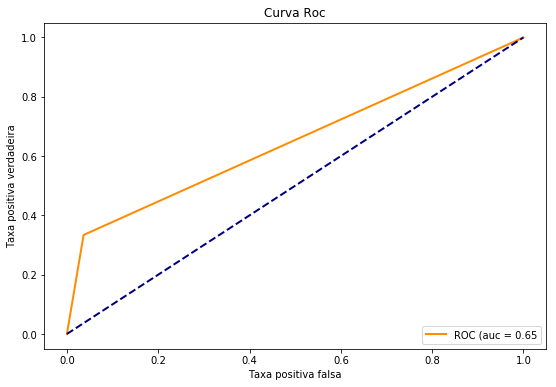

In [35]:
plot_roc_curve(y_true=y_true2, y_score=y_score2)  #decision tree

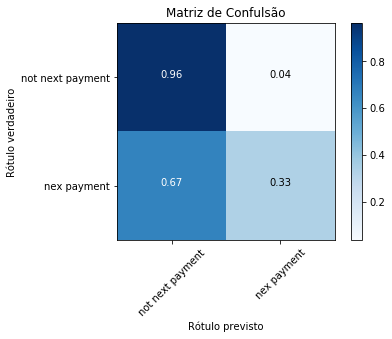

In [36]:
plot_confusion_matrix(cm=confusion_matrix(y_true=y_true2, y_pred=y_pred2),
                      class_names=["not next payment", "nex payment"]) # decision tree

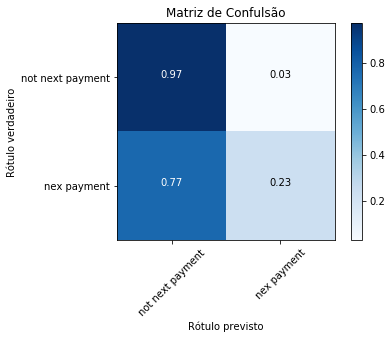

In [37]:
plot_confusion_matrix(cm=confusion_matrix(y_true=y_true, y_pred=y_pred),    #LogisticRegression
                      class_names=["not next payment", "nex payment"])